Generation: 50. Loss = 0.5279015
Generation: 100. Loss = 0.22871476
Generation: 150. Loss = 0.17977345
Generation: 200. Loss = 0.10789865
Generation: 250. Loss = 0.24002916
Generation: 300. Loss = 0.15323998
Generation: 350. Loss = 0.1659011
Generation: 400. Loss = 0.09572482
Generation: 450. Loss = 0.12101425
Generation: 500. Loss = 0.1294937


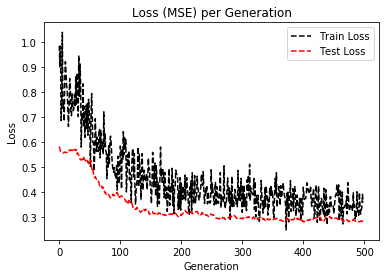

In [6]:
# 6-4 recipe 37
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn import datasets
from tensorflow.python.framework import ops
ops.reset_default_graph()

# load data
iris = datasets.load_iris()
x_vals = np.array([x[0:3] for x in iris.data])
y_vals = np.array([x[3] for x in iris.data])

sess = tf.Session()

seed = 3
tf.set_random_seed(seed)
np.random.seed(seed)

train_indices = np.random.choice(len(x_vals), round(len(x_vals)*0.8),
                                replace = False)
test_indices = np.array(list(set(range(len(x_vals))) - set(train_indices)))
x_vals_train = x_vals[train_indices]
x_vals_test = x_vals[test_indices]
y_vals_train = y_vals[train_indices]
y_vals_test = y_vals[test_indices]

def normalize_cols(m):
    col_max = m.max(axis=0)
    col_min = m.min(axis=0)
    return (m - col_min) / (col_max - col_min)

x_vals_train = np.nan_to_num(normalize_cols(x_vals_train))
x_vals_test = np.nan_to_num(normalize_cols(x_vals_test))

batch_size = 50

# define placeholder and variables
x_data = tf.placeholder(shape= [None, 3], dtype = tf.float32)
y_target = tf.placeholder(shape= [None, 1], dtype = tf.float32)

hidden_layer_nodes = 10

A1 = tf.Variable(tf.random_normal(shape = [3, hidden_layer_nodes]))
b1 = tf.Variable(tf.random_normal(shape = [hidden_layer_nodes]))
A2 = tf.Variable(tf.random_normal(shape = [hidden_layer_nodes, 1]))
b2 = tf.Variable(tf.random_normal(shape = [1]))

# create model
hidden_output = tf.nn.relu(tf.add(tf.matmul(x_data, A1), b1))
final_output = tf.nn.relu(tf.add(tf.matmul(hidden_output, A2), b2))

# define loss function
loss = tf.reduce_mean(tf.square(y_target - final_output))

# define optimization function
my_opt = tf.train.GradientDescentOptimizer(0.005)
train_step = my_opt.minimize(loss)

# initialize
init = tf.global_variables_initializer()
sess.run(init)

loss_vec = []
test_loss = []
for i in range(500):
    rand_index = np.random.choice(len(x_vals_train), size = batch_size)
    rand_x = x_vals_train[rand_index]
    rand_y = np.transpose([y_vals_train[rand_index]])
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
    
    temp_loss = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
    loss_vec.append(np.sqrt(temp_loss))
    
    test_temp_loss = sess.run(loss, feed_dict={
        x_data: x_vals_test,
        y_target: np.transpose([y_vals_test])})
    test_loss.append(np.sqrt(test_temp_loss))
    
    if (i+1) % 50 == 0:
        print('Generation: ' + str(i+1) + '. Loss = ' + str(temp_loss))
        
plt.plot(loss_vec, 'k--', label = 'Train Loss')
plt.plot(test_loss, 'r--', label = 'Test Loss')
plt.title('Loss (MSE) per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.legend(loc = 'upper right')
plt.show()

In [15]:
# 6-5 recipe 38
## dim 1
import tensorflow as tf
import numpy as np
from tensorflow.python.framework import ops

ops.reset_default_graph()
sess = tf.Session()

# define placeholder and variables
data_size = 25
data_1d = np.random.normal(size = data_size)
# [[1],[2],,,[25]]
x_input_1d = tf.placeholder(dtype = tf.float32, shape = [data_size])

def conv_layer_1d(input_1d, my_filter):
    # add dim
    ## [1, a]
    input_2d = tf.expand_dims(input_1d, 0)
    ## [1, 1, a]
    input_3d = tf.expand_dims(input_2d, 0)
    ## [1, 1, a, 1] -> [batch, in_height, "in_width", in_channels]
    input_4d = tf.expand_dims(input_3d, 3)
    # do convolution
    ## strides: pattern of moving filter [1, stride, stride, 1]
    ## padding: effect the size of output(VALID: input size = output size)
    convolution_output = tf.nn.conv2d(input_4d, filter = my_filter,
                                     strides=[1,1,1,1], padding="VALID")
    # reduce dim
    ## Removes dimensions of size 1 from the shape of a tensor.
    ## [1, 1, a, 1] -> [a]
    conv_output_1d = tf.squeeze(convolution_output)
    return(conv_output_1d)

# filter: [filter_height, "filter_width", in_channels, channel_multiplier(:size of output)]
my_filter = tf.Variable(tf.random_normal(shape = [1, 5, 1, 1]))
my_convolution_output = conv_layer_1d(x_input_1d, my_filter)

def activation(input_1d):
    return (tf.nn.relu(input_1d))

my_activation_output = activation(my_convolution_output)

def max_pool(input_1d, width):
    input_2d = tf.expand_dims(input_1d, 0)
    input_3d = tf.expand_dims(input_2d, 0)
    input_4d = tf.expand_dims(input_3d, 3)
    
    pool_output = tf.nn.max_pool(input_4d, ksize=[1, 1, width, 1],
                                strides = [1, 1, 1, 1], padding = 'VALID')
    
    pool_output_1d = tf.squeeze(pool_output)
    return(pool_output_1d)

my_maxpool_output = max_pool(my_activation_output, width = 5)

def fully_connected(input_layer, num_outputs):
    weight_shape = tf.squeeze(tf.stack(
        [tf.shape(input_layer), [num_outputs]]))
    weight = tf.random_normal(weight_shape, stddev=0.1)
    bias = tf.random_normal(shape = [num_outputs])
    input_layer_2d = tf.expand_dims(input_layer, 0)
    # y = a * x + b
    full_output = tf.add(tf.matmul(input_layer_2d, weight), bias)
    full_output_1d = tf.squeeze(full_output)
    return(full_output_1d)

my_full_output = fully_connected(my_maxpool_output, 5)

# initialize
init = tf.global_variables_initializer()
sess.run(init)

feed_dict = {x_input_1d: data_1d}

print('Input = array of length 25')
print('Convolution w/filter, length = 5, stride size = 1, results in an array of length 21:')
print(sess.run(my_convolution_output, feed_dict = feed_dict))

print('Input = the above array of length 21')
print('ReLU element wise returns the array of length 21:')
print(sess.run(my_activation_output, feed_dict = feed_dict))

print('Input = the above array of length 21')
print('MaxPool, stride size = 1, results in an array of length 17:')
print(sess.run(my_maxpool_output, feed_dict = feed_dict))

print('Input = the above array of length 17')
print('Fully connected layer on all four rows with five outputs:')
print(sess.run(my_full_output, feed_dict = feed_dict))

Input = array of length 25
Convolution w/filter, length = 5, stride size = 1, results in an array of length 21:
[ 0.14856875  0.5955459  -0.03666271  0.8424253   0.50908566 -0.25098908
  0.5367538   0.10870323 -0.2795636  -0.6094694  -0.45228207  0.07398408
  0.02250871 -0.2612415  -0.12616123  0.53680134  0.66181767 -0.4217523
 -0.1393376   0.13495742  0.01901602]
Input = the above array of length 21
ReLU element wise returns the array of length 21:
[0.14856875 0.5955459  0.         0.8424253  0.50908566 0.
 0.5367538  0.10870323 0.         0.         0.         0.07398408
 0.02250871 0.         0.         0.53680134 0.66181767 0.
 0.         0.13495742 0.01901602]
Input = the above array of length 21
MaxPool, stride size = 1, results in an array of length 17:
[0.8424253  0.8424253  0.8424253  0.8424253  0.5367538  0.5367538
 0.5367538  0.10870323 0.07398408 0.07398408 0.07398408 0.53680134
 0.66181767 0.66181767 0.66181767 0.66181767 0.66181767]
Input = the above array of length 17
F

In [17]:
# 6-5 recipe 38
## dim 2
from tensorflow.python.framework import ops

ops.reset_default_graph()
sess = tf.Session()

# define placeholder and variables
data_size = [10, 10]
data_2d = np.random.normal(size = data_size)
x_input_2d = tf.placeholder(dtype = tf.float32, shape = data_size)

def conv_layer_2d(input_2d, my_filter):
    # add dim
    ## [1, a, b]
    input_3d = tf.expand_dims(input_2d, 0)
    ## [1, a, b, 1] -> [batch, in_height, "in_width", in_channels]
    input_4d = tf.expand_dims(input_3d, 3)
    # do convolution
    convolution_output = tf.nn.conv2d(input_4d, filter = my_filter,
                                     strides=[1,2,2,1], padding="VALID")
    # reduce dim
    ## Removes dimensions of size 1 from the shape of a tensor.
    ## [1, a, b, 1] -> [a, b]
    conv_output_2d = tf.squeeze(convolution_output)
    return(conv_output_2d)

# filter: [filter_height, "filter_width", in_channels, channel_multiplier(:size of output)]
my_filter = tf.Variable(tf.random_normal(shape = [2, 2, 1, 1]))
my_convolution_output = conv_layer_2d(x_input_2d, my_filter)

def activation(input_2d):
    return (tf.nn.relu(input_2d))

my_activation_output = activation(my_convolution_output)

def max_pool(input_2d, width, height):
    input_3d = tf.expand_dims(input_2d, 0)
    input_4d = tf.expand_dims(input_3d, 3)
    
    pool_output = tf.nn.max_pool(input_4d, ksize=[1, height, width, 1],
                                strides = [1, 1, 1, 1], padding = 'VALID')
    
    pool_output_2d = tf.squeeze(pool_output)
    return(pool_output_2d)

my_maxpool_output = max_pool(my_activation_output, width = 2, height = 2)

def fully_connected(input_layer, num_outputs):
    flat_input = tf.reshape(input_layer, [-1])
    weight_shape = tf.squeeze(tf.stack(
        [tf.shape(flat_input), [num_outputs]]))
    weight = tf.random_normal(weight_shape, stddev=0.1)
    bias = tf.random_normal(shape = [num_outputs])
    input_2d = tf.expand_dims(flat_input, 0)
    # y = a * x + b
    full_output = tf.add(tf.matmul(input_2d, weight), bias)
    full_output_2d = tf.squeeze(full_output)
    return(full_output_2d)

my_full_output = fully_connected(my_maxpool_output, 5)

# initialize
init = tf.global_variables_initializer()
sess.run(init)

feed_dict = {x_input_2d: data_2d}

print('Input = [10, 10] array')
print('[2, 2] Convolution, stride size = [2, 2], results in the [5, 5] array:')
print(sess.run(my_convolution_output, feed_dict = feed_dict))

print('Input = the above [5, 5] array')
print('ReLU element wise returns the [5, 5] array:')
print(sess.run(my_activation_output, feed_dict = feed_dict))

print('Input = the above [5, 5] array')
print('MaxPool, stride size = [1, 1], results in the [4, 4] array')
print(sess.run(my_maxpool_output, feed_dict = feed_dict))

print('Input = the above [4, 4] array')
print('Fully connected layer on all 4 rows results in 5 outputs:')
print(sess.run(my_full_output, feed_dict = feed_dict))

Input = [10, 10] array
[2, 2] Convolution, stride size = [2, 2], results in the [5, 5] array:
[[-0.6700752   1.8198721   1.4178371   0.44005162  2.601728  ]
 [ 0.05742282 -2.0398755   0.57646954  2.67273    -0.54078466]
 [ 1.532934    0.9196137   0.71011215  1.5584911   0.38921696]
 [-0.03958464  1.0434458   1.108611    0.9375706   3.100013  ]
 [ 0.38061583  0.88077825 -1.9488468  -1.1278431   0.83328736]]
Input = the above [5, 5] array
ReLU element wise returns the [5, 5] array:
[[0.         1.8198721  1.4178371  0.44005162 2.601728  ]
 [0.05742282 0.         0.57646954 2.67273    0.        ]
 [1.532934   0.9196137  0.71011215 1.5584911  0.38921696]
 [0.         1.0434458  1.108611   0.9375706  3.100013  ]
 [0.38061583 0.88077825 0.         0.         0.83328736]]
Input = the above [5, 5] array
MaxPool, stride size = [1, 1], results in the [4, 4] array
[[1.8198721 1.8198721 2.67273   2.67273  ]
 [1.532934  0.9196137 2.67273   2.67273  ]
 [1.532934  1.108611  1.5584911 3.100013 ]
 [1.0

Generation: 25. Loss = 1992.519
Generation: 50. Loss = 868.2045
Generation: 75. Loss = 720.9928
Generation: 100. Loss = 610.97534
Generation: 125. Loss = 452.60284
Generation: 150. Loss = 474.33493
Generation: 175. Loss = 568.76624
Generation: 200. Loss = 518.18713


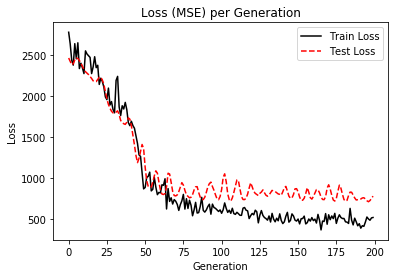

On predicting the category of low birthweight from regression \ output (<2500g):
Train Accuracy: 0.7615894039735099
Test Accuracy: 0.6578947368421053


In [63]:
# 6-6 recipe 39
import tensorflow as tf
import matplotlib.pyplot as plt
import requests
import numpy as np
import csv
import os

birth_weight_file = "./data/birthweight.dat"

if not os.path.exists(birth_weight_file):
    birthdata_url = 'https://github.com/nfmcclure/tensorflow_cookbook/raw/master/01_Introduction/07_Working_with_Data_Sources/birthweight_data/birthweight.dat'
    birth_file = requests.get(birthdata_url)
    birth_data = birth_file.text.split('\r\n')
    birth_header = birth_data[0].split('\t')
    birth_data = [[float(x) for x in y.split('\t') if len(x)>=1]
                for y in birth_data[1:] if len(y)>=1]
    with open(birth_weight_file, "w") as f:
        writer = csv.writer(f)
        writer.writerows([birth_header])
        writer.writerows(birth_data)
        f.close()

birth_data = []
with open(birth_weight_file, newline='') as csvfile:
    csv_reader = csv.reader(csvfile)
    birth_header = next(csv_reader)
    for row in csv_reader:
        birth_data.append(row)
            
birth_data = [[float(x) for x in row] for row in birth_data]
# y: weight of baby
y_vals = np.array([x[8] for x in birth_data])
cols_of_interest = ['AGE', 'LWT', 'RACE', 'SMOKE', 'PTL', 'HT', 'UI']
x_vals = np.array([[x[ix] for ix, feature in enumerate(birth_header)
        if feature in cols_of_interest] for x in birth_data])

sess = tf.Session()

seed = 15
# if you want same output, you need to write seed in function ex: random_normal(,seed = xx) 
tf.set_random_seed(seed)
np.random.seed(seed)

batch_size = 100

train_indices = np.random.choice(len(x_vals), round(len(x_vals)*0.8),
                                     replace=False)
test_indices = np.array(list(set(range(len(x_vals))) - set(train_indices)))
x_vals_train = x_vals[train_indices]
x_vals_test = x_vals[test_indices]
y_vals_train = y_vals[train_indices]
y_vals_test = y_vals[test_indices]

def normalize_cols(m):
        col_max = m.max(axis=0)
        col_min = m.min(axis=0)
        return (m - col_min) / (col_max - col_min)
x_vals_train = np.nan_to_num(normalize_cols(x_vals_train))
x_vals_test = np.nan_to_num(normalize_cols(x_vals_test))

# define variable and placeholder
def init_weight(shape, st_dev):
    weight = tf.Variable(tf.random_normal(shape, stddev = st_dev, seed = 15))
    return(weight)

def init_bias(shape, st_dev):
    bias = tf.Variable(tf.random_normal(shape, stddev = st_dev, seed = 15))
    return(bias)

x_data = tf.placeholder(shape = [None, 7], dtype = tf.float32)
y_target = tf.placeholder(shape = [None, 1], dtype = tf.float32)

def fully_connected(input_layer, weights, biases):
    layer = tf.add(tf.matmul(input_layer, weights), biases)
    return(tf.nn.relu(layer))

# define model
weight_1 = init_weight(shape=[7, 25], st_dev = 10.0)
bias_1 = init_bias(shape = [25], st_dev = 10.0)
layer_1 = fully_connected(x_data, weight_1, bias_1)

weight_2 = init_weight(shape=[25, 10], st_dev = 10.0)
bias_2 = init_bias(shape = [10], st_dev = 10.0)
layer_2 = fully_connected(layer_1, weight_2, bias_2)

weight_3 = init_weight(shape=[10, 3], st_dev = 10.0)
bias_3 = init_bias(shape = [3], st_dev = 10.0)
layer_3 = fully_connected(layer_2, weight_3, bias_3)

weight_4 = init_weight(shape=[3, 1], st_dev = 10.0)
bias_4 = init_bias(shape = [1], st_dev = 10.0)
final_output = fully_connected(layer_3, weight_4, bias_4)

# define loss function
loss = tf.reduce_mean(tf.abs(y_target - final_output))

# define optimization function
my_opt = tf.train.AdamOptimizer(0.05)
train_step = my_opt.minimize(loss)

# initialize
init = tf.global_variables_initializer()
sess.run(init)

# update variables
loss_vec = []
test_loss = []
for i in range(200):
    rand_index = np.random.choice(len(x_vals_train), size = batch_size)
    rand_x = x_vals_train[rand_index]
    rand_y = np.transpose([y_vals_train[rand_index]])
    sess.run(train_step, feed_dict = {x_data: rand_x, y_target: rand_y})
    
    temp_loss = sess.run(loss, feed_dict={
        x_data: rand_x,
        y_target: rand_y
    })
    loss_vec.append(temp_loss)
    
    test_temp_loss = sess.run(loss, feed_dict={
        x_data: x_vals_test,
        y_target: np.transpose([y_vals_test])
    })
    test_loss.append(test_temp_loss)

    if (i+1) % 25 == 0:
        print('Generation: ' + str(i+1) + '. Loss = ' + str(temp_loss))
        

plt.plot(loss_vec, 'k-', label='Train Loss')
plt.plot(test_loss, 'r--', label='Test Loss')
plt.title('Loss (MSE) per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

actuals = np.array([x[0] for x in birth_data])
train_actuals = actuals[train_indices]
test_actuals = actuals[test_indices]
# predict 1 or 0 by using predict of baby's weight
train_preds = [x[0] for x in sess.run(final_output,
                                    feed_dict={x_data: x_vals_train})]
test_preds = [x[0] for x in sess.run(final_output,
                                    feed_dict={x_data: x_vals_test})]
train_preds = np.array([1.0 if x<2500.0 else 0.0 for x in train_preds])
test_preds = np.array([1.0 if x<2500.0 else 0.0 for x in test_preds])
# 正解率を出力
train_acc = np.mean([x == y for x,y in zip(train_preds, train_actuals)])
test_acc = np.mean([x == y for x,y in zip(test_preds, test_actuals)])
print('On predicting the category of low birthweight from regression \ output (<2500g):')
print('Train Accuracy: {}'.format(train_acc))
print('Test Accuracy: {}'.format(test_acc))